<a href="https://colab.research.google.com/github/einsteinxx/STOCKS_UTILS/blob/main/get_stock_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600

### Imports
%matplotlib inline 
#inline




import os
import sys
import random
import math
import string
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import matplotlib.patches as patches
import imageio
from pathlib import Path             #file path tools
from shapely.geometry import Polygon #make polygons for Intersections
from PIL import Image  
import datetime

import json
import pandas as pd

import csv
!pip3 install -q yfinance #scipy==1.2.0


import yfinance as yf


In [32]:
#define the ticker symbol
tickerSymbol = 'ANPC'
tickerSymbols =['ARKK','PFE']

#get data on this ticker
tData = {}
tDataDf ={}
tickerData = yf.Ticker(tickerSymbol)
for ii in tickerSymbols:
    tData[ii] = yf.Ticker(ii)
    tDataDf[ii] = tData[ii].history(period='1d', start='2010-1-1', end='2021-02-25') 

#get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2010-1-1', end='2021-02-25')

#see your data
tickerDf


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-31,10.990,11.200,9.660,10.12,107400,0,0
2020-02-03,10.090,10.910,10.090,10.62,39200,0,0
2020-02-04,10.624,10.893,9.842,10.64,31300,0,0
2020-02-05,10.600,10.600,9.800,10.00,44600,0,0
2020-02-06,10.150,10.250,9.800,10.01,23700,0,0
...,...,...,...,...,...,...,...
2021-02-18,8.120,8.200,6.930,7.46,284000,0,0
2021-02-19,7.500,7.540,7.010,7.23,120600,0,0
2021-02-22,7.010,7.189,7.000,7.14,110000,0,0


In [33]:
#
# Get listing of all ticker values from daily csv list
#
import urllib.request

url = 'https://s3.amazonaws.com/quandl-production-static/end_of_day_us_stocks/ticker_list.csv'
#urllib.request.urlretrieve(url, '/Users/scott/Downloads/cat.jpg')

In [34]:
np.shape(tickerDf)

closing_dates_dict={}
closing_vals_dict={}
for keyname in tDataDf.keys():
    closing_dates_dict[keyname] = tDataDf[keyname].index
    closing_dates_dict[keyname] = closing_dates_dict[keyname].values.astype('datetime64[s]')
    closing_vals_dict[keyname] = tDataDf[keyname]['Close']

closing_val = tickerDf['Close']

closing_dates =tickerDf.index

# df['Time'] = df['Time'].astype('datetime64[s]')
print(type(closing_dates))
dt = closing_dates.values
closing_dates =closing_dates.values.astype('datetime64[s]')



<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [35]:

#dd = '2018-06-29T08:15:27.2438601'
#print(type(dd))
#date_time_str = dd

day_dict = {}
month_dict={}
year_dict = {}
for keyname in closing_dates_dict.keys():
    day_dict[keyname] = []
    month_dict[keyname]=[]
    year_dict[keyname] = []
    for ii in closing_dates_dict[keyname]:
        date_time_obj = datetime.datetime.strptime(str(ii),"%Y-%m-%dT%H:%M:%S")
        year_dict[keyname].append(date_time_obj.year)
        month_dict[keyname].append(date_time_obj.month)
        day_dict[keyname].append(date_time_obj.day)


###################
day = []
month=[]
year=[]
for ii in closing_dates:
    date_time_obj = datetime.datetime.strptime(str(ii),"%Y-%m-%dT%H:%M:%S")
                                           #'%Y-%m-%dT%H:%M:%S.%f')

    #print('Date:', date_time_obj.date())
    #print('Time:', date_time_obj.time())
    #print('Date-time:', date_time_obj)
    year.append(date_time_obj.year)
    month.append(date_time_obj.month)
    day.append(date_time_obj.day)


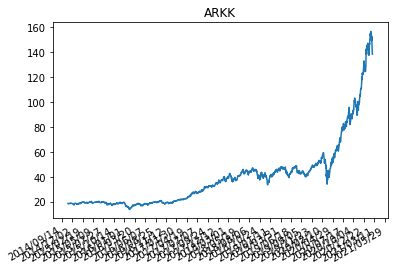

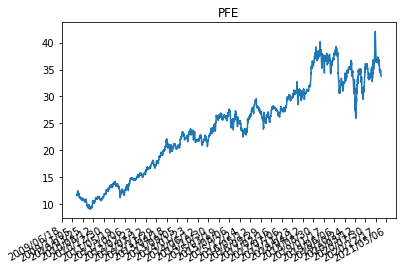

In [36]:
import matplotlib.dates as dates


del dt
import datetime as dt



new_x ={}
for keyname in year_dict.keys():
    new_x[keyname]=[]
    for ii in range(0,len(day_dict[keyname])):
        newdate = str(year_dict[keyname][ii]) + '/' + str(month_dict[keyname][ii]).zfill(2) + '/' + str(day_dict[keyname][ii]).zfill(2)
        x = dt.datetime.strptime(newdate,'%Y/%m/%d').date()
        new_x[keyname].append(x)




import matplotlib.dates as mdates

for keyname in closing_vals_dict.keys():
    y = closing_vals_dict[keyname]
    #get interval for date tics
    tic_interval = np.int(len(closing_vals_dict[keyname])/20)
    plt.figure()
    plt.title(keyname)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=tic_interval))
    plt.plot(new_x[keyname],y)
    plt.gcf().autofmt_xdate()

In [37]:
#
# Get first date that both stocks have in common. This will be use to do overlay
# plots when they're not the same size
#
s1=tickerSymbols[0]
s2 = tickerSymbols[1]
ix = list(set(new_x[s1]).intersection(new_x[s2]))
print(type(ix))
print(ix[0])
print(type(ix[0]))
ix.sort() #sort is in place, so don't assign it, it changes the list in memory
ix[0]


#find where this first sorted value is in each datetime list
ystart ={}
for keyname in new_x.keys():
    for counter,ii in enumerate(new_x[keyname]):
        if (ii < ix[0]):
            #skip this one
            continue
        else:
            ystart[keyname] = counter
            break

print(new_x[s1][ystart[s1]])
print(ystart)
print(closing_vals_dict[s1][0])
print(len(closing_vals_dict[s1][ystart[s1]:]))

<class 'list'>
2018-05-25
<class 'datetime.date'>
2014-10-31
{'ARKK': 0, 'PFE': 1216}
18.69798469543457
1589


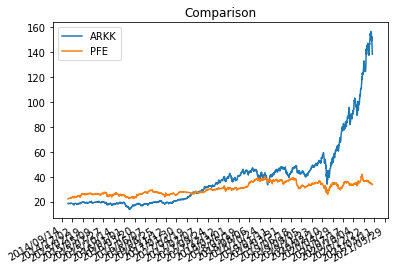

In [38]:
plt.figure()
plt.title('Comparison')
for counter,keyname in enumerate(closing_vals_dict.keys()):
    y = closing_vals_dict[keyname][ystart[keyname]:]
    #get interval for date tics
    tic_interval = np.int(len(y)/20)
    #plt.figure()
    #plt.title(keyname)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=tic_interval))
    plt.plot(new_x[keyname][ystart[keyname]:],y,label=keyname)
    plt.gcf().autofmt_xdate()
    plt.legend()